# Introduction

The aim of this project is to perform satellite image classification on the EuroSAT dataset, see https://github.com/phelber/EuroSAT. The authors present a novel dataset based on  Sentinel-2 satellite images. The dataset has 13 spectral bands, and includes 10 classes with 27,000 labelled and geo-referenced images. This project will compare various CNN models to the state-of-the-art vision transformer model.

The notebook below tests the ResNet50 model on the EuroSAT dataset. The ResNet50 model is based on the following paper: https://arxiv.org/abs/1512.03385v1

The implementation is based on the tutorial below:
https://colab.research.google.com/drive/15oRSLVWUfxkQd3oEhuNIHzT-l5phfutO?usp=sharing#scrollTo=AKm6UgGpix0B

In [1]:
# first, import required libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow.keras.applications.resnet import ResNet50, preprocess_input

# Install Keras Flops
!pip install keras-flops

from keras_flops import get_flops

     |████████████████████████████████| 462 kB 12.0 MB/s 


# Data Preparation #
This step involves preparing the data, gathering the class names, and load the dataset to be used.

In [2]:
# get dataset
dataset = tfds.builder('eurosat')
info = dataset.info

In [3]:
# get class names - we have 10 classes in the EuroSAT dataset
class_names = []
for i in range(info.features["label"].num_classes):
  class_names.append(info.features["label"].int2str(i))

class_names

['AnnualCrop',
 'Forest',
 'HerbaceousVegetation',
 'Highway',
 'Industrial',
 'Pasture',
 'PermanentCrop',
 'Residential',
 'River',
 'SeaLake']

In [4]:
# select the training data
list(info.splits.keys())

['train']

In [5]:
# load the dataset from TensorFlow Datasets 
# in this experiment, we will have a 80/20/20 train/test/validate split
(train, val, test) = tfds.load("eurosat/rgb", split=["train[:80%]", "train[80%:90%]", "train[90%:]"])

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/eurosat/rgb/2.0.0.incomplete8NP8LG/eurosat-train.tfrecord


  0%|          | 0/27000 [00:00<?, ? examples/s]

Dataset eurosat downloaded and prepared to /root/tensorflow_datasets/eurosat/rgb/2.0.0. Subsequent calls will reuse this data.


In [6]:
type(train)

tensorflow.python.data.ops.dataset_ops.PrefetchDataset

In [7]:
# load next batch to be trained
datapoint = next(iter(train))

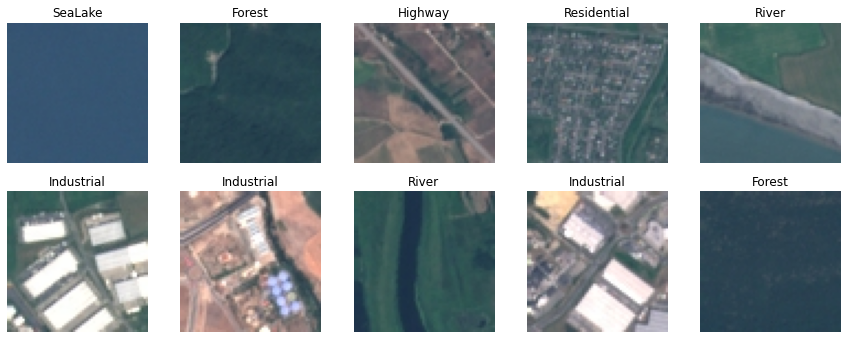

In [8]:
# view samples of the dataset
plt.figure(figsize=(15, 15))
for i, datapoint in enumerate(tfds.as_numpy(train.take(10))):
  ax = plt.subplot(5, 5, i+1)
  plt.imshow(datapoint["image"])
  plt.title(class_names[datapoint["label"]])
  plt.axis("off")
plt.show()

In [9]:
# set the number of epochs, batch, buffer size
NUM_EPOCHS = 5
BATCH_SIZE = 64
BUFFER_SIZE = 1000

# we will have 180x180 images
IMAGE_SHAPE = [180, 180]
NUM_CLASSES = info.features["label"].num_classes

In [10]:
# we create a random value to evaluate whether we apply augmentation to the input images
# this is designed to prevent overfitting
tf.random.uniform(())  # This will generate a random floating number from 0-1

<tf.Tensor: shape=(), dtype=float32, numpy=0.2609359>

In [11]:
@tf.function
def prepare_training_data(datapoint):
  input_image = tf.image.resize(datapoint["image"], IMAGE_SHAPE)

  if tf.random.uniform(()) > 0.5:
    # apply data augmentation techniques if the uniform value is above a threshold (0.5)
    input_image = tf.image.random_flip_left_right(input_image)
    input_image = tf.image.random_flip_up_down(input_image)
    input_image = tf.image.random_brightness(input_image, max_delta=0.3)
    input_image = tf.image.random_saturation(input_image, lower=0.75, upper=1.5)
    input_image = tf.image.random_contrast(input_image, lower=0.75, upper=1.5)

  input_image = preprocess_input(input_image)

  return input_image, datapoint["label"]

def prepare_validation_data(datapoint):
  input_image = tf.image.resize(datapoint["image"], IMAGE_SHAPE)
  input_image = preprocess_input(input_image)

  return input_image, datapoint["label"]

In [12]:
# use prefetch to prepare the training dataset
train = train.map(prepare_training_data, num_parallel_calls=tf.data.experimental.AUTOTUNE)
validation = val.map(prepare_validation_data)

train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
validation_dataset = validation.batch(BATCH_SIZE)

# Build the Model: ResNet50 #
We use Keras to build the ResNet50 model.

In [13]:
# build model using ResNet50
resnet = ResNet50(input_shape=IMAGE_SHAPE+[3], weights='imagenet', include_top=False)

# set trainable layers to false
for layer in resnet.layers:
  layer.trainable = False

# we employ a pooling, flatten, and dense layer
x = tf.keras.layers.GlobalAveragePooling2D()(resnet.output)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
predict = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(x)

model = tf.keras.models.Model(inputs=resnet.input, outputs=predict)

94781440/94765736 [==============================] - 1s 0us/step


In [14]:
# compile model
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    optimizer='adam',
    metrics=['accuracy']
)

In [15]:
STEPS_PER_EPOCH = int(info.splits["train"].num_examples * 0.8)//BATCH_SIZE
VALIDATION_STEPS = int(info.splits["train"].num_examples * 0.1)//BATCH_SIZE

# Calculate Model Inference Time

In this section, we calculate the theoretical model inference time for each experiment using the following process:

1. Show that Google Colab uses the NVIDIA Tesla T4 GPU.

2. Calculate the number of FLOPS used by the NVIDIA Tesla T4 GPU using the following formula (source: https://stackoverflow.com/questions/71393256/how-to-calculate-theoretical-inference-time-of-a-network-based-on-gpu)

***Number of CUDA Cores * Number of MHz * 2 * 10^-6***

3. We must then calculate the number of FLOPS in the ResNet model. We use the get_flops() function here with a batch size of 64.

4. Finally, the theoretical inference time is calculated by finding (ResNet FLOPS/Colab FLOPS). This value is multiplied by 1,000 to obtain a time in ms.

**Step 1**

In [16]:
# We observe that Google Colab uses an NVIDIA Tesla T4 GPU - see information below
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-334ce787-4291-fc81-c849-31a66c3f7a64)


**Step 2**

In [17]:
# Use specs to calculate Google Colab's NVIDIA Tesla T4 GPU teraflops https://www.techpowerup.com/gpu-specs/tesla-t4.c3316
colab_teraflops = 2560 * 585 * 2 * 10**-6
print('Colab teraflops: ', colab_teraflops)

Colab teraflops:  2.9952


**Step 3**

In [18]:
# Get number of teraflops of ResNet model

resnet_flops = get_flops(model, batch_size=64)
resnet_teraflops = resnet_flops * 10**-12
print('ResNet teraflops: ', resnet_teraflops)

Instructions for updating:
Use `tf.compat.v1.graph_util.tensor_shape_from_node_def_name`


Instructions for updating:
Use `tf.compat.v1.graph_util.tensor_shape_from_node_def_name`


ResNet teraflops:  0.348196220288


**Step 4**

In [19]:
# Calculate theoretical inference time
# Source: https://stackoverflow.com/questions/71393256/how-to-calculate-theoretical-inference-time-of-a-network-based-on-gpu

print(f"Theoretical Inference Time: {(resnet_teraflops / colab_teraflops)*1000} ms")

Theoretical Inference Time: 116.25140901709402 ms


# Train the Model
We train the ResNet50 model for 5 epochs.

In [ ]:
history = model.fit(
    train_dataset,
    epochs = NUM_EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=validation_dataset,
    validation_steps=VALIDATION_STEPS
)

Epoch 1/5
337/337 [==============================] - 140s 367ms/step - loss: 0.2484 - accuracy: 0.9175 - val_loss: 0.1486 - val_accuracy: 0.9520
Epoch 2/5
337/337 [==============================] - 111s 326ms/step - loss: 0.1224 - accuracy: 0.9577 - val_loss: 0.1670 - val_accuracy: 0.9505
Epoch 3/5
337/337 [==============================] - 110s 325ms/step - loss: 0.0834 - accuracy: 0.9709 - val_loss: 0.1188 - val_accuracy: 0.9643
Epoch 4/5
337/337 [==============================] - 110s 326ms/step - loss: 0.0593 - accuracy: 0.9795 - val_loss: 0.1381 - val_accuracy: 0.9606
Epoch 5/5
337/337 [==============================] - 109s 325ms/step - loss: 0.0461 - accuracy: 0.9850 - val_loss: 0.1342 - val_accuracy: 0.9628


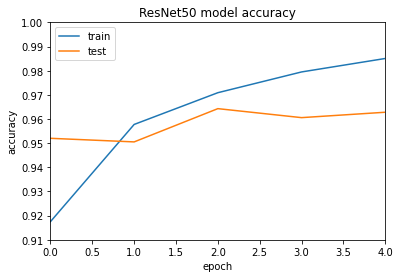

<Figure size 2592x2592 with 0 Axes>

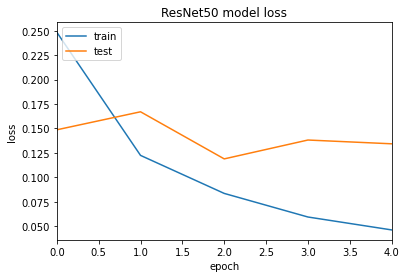

<Figure size 2592x2592 with 0 Axes>

In [ ]:
# plot the model's performance on the validation set
import pandas as pd

# plot summary for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('ResNet50 model accuracy')
plt.ylabel('accuracy')
plt.xlim(0,4)
plt.ylim(0.91, 1.00)
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.figure(figsize=(36,36))
plt.show()

# plot summary for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('ResNet50 model loss')
plt.ylabel('loss')
plt.xlim(0,4)
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.figure(figsize=(36,36))
plt.show()

In [ ]:
test_dataset = test.map(prepare_validation_data)
test_dataset = test_dataset.batch(BATCH_SIZE)

# Evaluate the Model
Evaluate the model's performance on the test dataset. 
Compute loss and accuracy.

In [ ]:
eval = model.evaluate(test_dataset)
print('Loss: ', eval[0])
print('Accuracy: ', eval[1])

43/43 [==============================] - 13s 298ms/step - loss: 0.1644 - accuracy: 0.9537
Loss:  0.164363294839859
Accuracy:  0.9537037014961243


# Show Predictions
Show how well the model classifies images after training.

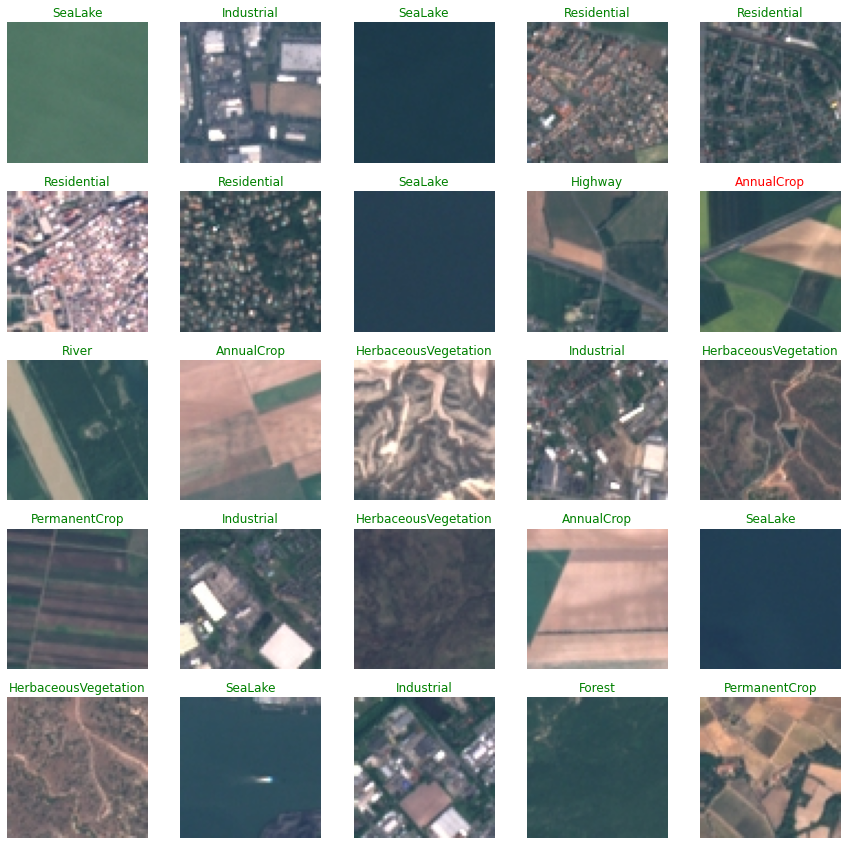

In [ ]:
plt.figure(figsize=(15, 15))
for i, datapoint in enumerate(tfds.as_numpy(test.take(25))):
  ax = plt.subplot(5, 5, i+1)
  plt.imshow(datapoint["image"])
  image = tf.image.resize(datapoint["image"], IMAGE_SHAPE)
  image = preprocess_input(image)
  image = np.expand_dims(image, axis=0)

  if datapoint["label"] == np.argmax(model.predict(image)):
    plt.title(class_names[np.argmax(model.predict(image))], color="green")
  else:
    plt.title(class_names[np.argmax(model.predict(image))], color="red")

  plt.axis("off")

plt.show()